# Lab 7: Graph ML Final Project
### Author: Nigel Nelson
### Date: 2/13/23
---
This notebook is simply meant to document and explain the structuring of data, how models were created, how models were trained, and how experiments were conducted. As such the models in this notebook were only trained for 5 epochs as examples. Due to the number of experiments ran, python scripts were created for each experiment and ran remotely using SBATCH shell scripts. These all can be found in /final_project_experiments, and the outputs of these experiments can be found in /final_project_experiments/Experiment_outputs. To interpret the Slurm outputs, SBATCH _Job_Keys.txt can be used to relate Slurm jobs to experiments ran.
#### Import required libraries
** Note, must download Inner_Speech_Dataset repo from https://github.com/N-Nieto/Inner_Speech_Dataset **

In [1]:
import os
import sys
from pathlib import Path

# Add directory with Inner_Speech_Repo
sys.path.append(str(Path.cwd()) + '/final_project_experiments')

In [45]:
import mne 
import pickle
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt

from Inner_Speech_Dataset.Python_Processing.Data_extractions import  Extract_data_from_subject, Extract_subject_from_BDF
from Inner_Speech_Dataset.Python_Processing.Data_processing import  Select_time_window,  Filter_by_condition


mne.set_log_level(verbose='warning') #to avoid info at terminal
warnings.filterwarnings(action = "ignore", category = DeprecationWarning ) 
warnings.filterwarnings(action = "ignore", category = FutureWarning )

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv, Linear, GATv2Conv
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import global_max_pool
from sklearn.metrics import precision_recall_fscore_support

## Define global parameters for experiments:

In [26]:
### Hyperparameters


num_epochs = 5
hidden_dim = 256
heads = 8

feature_dim = 512
num_classes = 4
kernel_size = 5
num_nodes = 128

# The root dir that points to the folder that contains the database
root_dir = "/data/datasets/inner_speech/ds003626/"
# Data Type
datatype = "EEG"
# Sampling rate
fs = 256
# Select the useful part of each trial. Time in seconds
t_start = 1.5
t_end = 3.5
# Subject number
NS = 1
# Block number of data
BN = 1

#### Load .bdf file:
Retrieve .bdf format of the patients file in order to access header attributes such as the channel names.

In [4]:
X, Y = Extract_subject_from_BDF(root_dir, NS, BN)

#### Build channel name to index dictionary:
Create a dictionary where the key is the name of the channel, and the value is the index of the channel when the channels are loaded as a 2D matrix. This allows for an edge_index list to be more intuitively constructed. 

In [5]:
channels = X.ch_names
chan_idxs = list(zip(channels, range(len(channels))))[:128]
chan_map = {x[0]: x[1] for x in chan_idxs}

#### Build adjacency list:
Use the previous dictionary to construct the adjacency list where all neighboring nodes are connected

In [6]:
edge_index = [
    [chan_map['C17'], chan_map['C16']],
    [chan_map['C17'], chan_map['C15']],
    [chan_map['C17'], chan_map['C18']],
    [chan_map['C17'], chan_map['C28']],
    [chan_map['C17'], chan_map['C29']],
    
    [chan_map['C16'], chan_map['C18']],
    [chan_map['C16'], chan_map['C15']],
    [chan_map['C16'], chan_map['C9']],
    [chan_map['C16'], chan_map['C8']],
    
    [chan_map['C8'], chan_map['C15']],
    [chan_map['C8'], chan_map['C9']],
    [chan_map['C8'], chan_map['C6']],
    [chan_map['C8'], chan_map['C7']],
    
    [chan_map['C7'], chan_map['C9']],
    [chan_map['C7'], chan_map['C6']],
    [chan_map['C7'], chan_map['B28']],
    [chan_map['C7'], chan_map['B27']],
    
    [chan_map['B27'], chan_map['C6']],
    [chan_map['B27'], chan_map['B28']],
    [chan_map['B27'], chan_map['B25']],
    [chan_map['B27'], chan_map['B26']],
    
    [chan_map['B26'], chan_map['B28']],
    [chan_map['B26'], chan_map['B25']],
    [chan_map['B26'], chan_map['B15']],
    [chan_map['B26'], chan_map['B14']],
    
    [chan_map['B14'], chan_map['B25']],
    [chan_map['B14'], chan_map['B15']],
    [chan_map['B14'], chan_map['B12']],
    [chan_map['B14'], chan_map['B11']],
    
    [chan_map['B11'], chan_map['B15']],
    [chan_map['B11'], chan_map['B12']],
    [chan_map['B11'], chan_map['B6']],
    [chan_map['B11'], chan_map['B7']],
    [chan_map['B11'], chan_map['B10']],
    [chan_map['B11'], chan_map['B8']],
    
    [chan_map['B7'], chan_map['B12']],
    [chan_map['B7'], chan_map['B6']],
    [chan_map['B7'], chan_map['A29']],
    [chan_map['B7'], chan_map['A28']],
    [chan_map['B7'], chan_map['A27']],
    [chan_map['B7'], chan_map['B8']],
    [chan_map['B7'], chan_map['B10']],
    
    [chan_map['A28'], chan_map['B6']],
    [chan_map['A28'], chan_map['A29']],
    [chan_map['A28'], chan_map['A22']],
    [chan_map['A28'], chan_map['A23']],
    [chan_map['A28'], chan_map['A24']],
    [chan_map['A28'], chan_map['A27']],
    [chan_map['A28'], chan_map['B8']],
    
    [chan_map['A23'], chan_map['A29']],
    [chan_map['A23'], chan_map['A22']],
    [chan_map['A23'], chan_map['A16']],
    [chan_map['A23'], chan_map['A15']],
    [chan_map['A23'], chan_map['A14']],
    [chan_map['A23'], chan_map['A24']],
    [chan_map['A23'], chan_map['A27']],
    
    [chan_map['A10'], chan_map['A16']],
    [chan_map['A10'], chan_map['A9']],
    [chan_map['A10'], chan_map['D30']],
    [chan_map['A10'], chan_map['D31']],
    [chan_map['A10'], chan_map['D32']],
    [chan_map['A10'], chan_map['A11']],
    [chan_map['A10'], chan_map['A14']],
    
    [chan_map['D31'], chan_map['A9']],
    [chan_map['D31'], chan_map['D30']],
    [chan_map['D31'], chan_map['D25']],
    [chan_map['D31'], chan_map['D24']],
    [chan_map['D31'], chan_map['D32']],
    [chan_map['D31'], chan_map['A11']],
    
    [chan_map['D24'], chan_map['D30']],
    [chan_map['D24'], chan_map['D25']],
    [chan_map['D24'], chan_map['D22']],
    [chan_map['D24'], chan_map['D23']],
    
    [chan_map['D23'], chan_map['D25']],
    [chan_map['D23'], chan_map['D22']],
    [chan_map['D23'], chan_map['D9']],
    [chan_map['D23'], chan_map['D8']],
    
    [chan_map['D8'], chan_map['D22']],
    [chan_map['D8'], chan_map['D9']],
    [chan_map['D8'], chan_map['D6']],
    [chan_map['D8'], chan_map['D7']],
    
    [chan_map['D7'], chan_map['D9']],
    [chan_map['D7'], chan_map['D6']],
    [chan_map['D7'], chan_map['C31']],
    [chan_map['D7'], chan_map['C30']],
    
    [chan_map['C30'], chan_map['D6']],
    [chan_map['C30'], chan_map['C31']],
    [chan_map['C30'], chan_map['C28']],
    [chan_map['C30'], chan_map['C29']],
    
    [chan_map['C29'], chan_map['C31']],
    [chan_map['C29'], chan_map['C28']],
    [chan_map['C29'], chan_map['C18']],
    
    [chan_map['C19'], chan_map['C18']],
    [chan_map['C19'], chan_map['C15']],
    [chan_map['C19'], chan_map['C14']],
    [chan_map['C19'], chan_map['C13']],
    [chan_map['C19'], chan_map['C20']],
    [chan_map['C19'], chan_map['C26']],
    [chan_map['C19'], chan_map['C27']],
    [chan_map['C19'], chan_map['C28']],
    
    [chan_map['C14'], chan_map['C15']],
    [chan_map['C14'], chan_map['C9']],
    [chan_map['C14'], chan_map['C10']],
    [chan_map['C14'], chan_map['C13']],
    [chan_map['C14'], chan_map['C20']],
    
    [chan_map['C10'], chan_map['C15']],
    [chan_map['C10'], chan_map['C9']],
    [chan_map['C10'], chan_map['C6']],
    [chan_map['C10'], chan_map['C5']],
    [chan_map['C10'], chan_map['C4']],
    [chan_map['C10'], chan_map['C13']],
    
    [chan_map['C5'], chan_map['C6']],
    [chan_map['C5'], chan_map['B28']],
    [chan_map['C5'], chan_map['B29']],
    [chan_map['C5'], chan_map['B30']],
    [chan_map['C5'], chan_map['C4']],
    
    [chan_map['B29'], chan_map['C6']],
    [chan_map['B29'], chan_map['B28']],
    [chan_map['B29'], chan_map['B25']],
    [chan_map['B29'], chan_map['B24']],
    [chan_map['B29'], chan_map['B23']],
    [chan_map['B29'], chan_map['B30']],
    
    [chan_map['B24'], chan_map['B28']],
    [chan_map['B24'], chan_map['B25']],
    [chan_map['B24'], chan_map['B15']],
    [chan_map['B24'], chan_map['B16']],
    [chan_map['B24'], chan_map['B17']],
    [chan_map['B24'], chan_map['B23']],
    [chan_map['B24'], chan_map['B30']],
    
    [chan_map['B16'], chan_map['B25']],
    [chan_map['B16'], chan_map['B15']],
    [chan_map['B16'], chan_map['B12']],
    [chan_map['B16'], chan_map['B13']],
    [chan_map['B16'], chan_map['B17']],
    [chan_map['B16'], chan_map['B23']],
    
    [chan_map['B13'], chan_map['B15']],
    [chan_map['B13'], chan_map['B12']],
    [chan_map['B13'], chan_map['B6']],
    [chan_map['B13'], chan_map['B5']],
    [chan_map['B13'], chan_map['B4']],
    [chan_map['B13'], chan_map['B17']],
    
    [chan_map['B5'], chan_map['B12']],
    [chan_map['B5'], chan_map['B6']],
    [chan_map['B5'], chan_map['A29']],
    [chan_map['B5'], chan_map['A30']],
    [chan_map['B5'], chan_map['A31']],
    [chan_map['B5'], chan_map['B4']],
    
    [chan_map['A30'], chan_map['B6']],
    [chan_map['A30'], chan_map['A29']],
    [chan_map['A30'], chan_map['A22']],
    [chan_map['A30'], chan_map['A21']],
    [chan_map['A30'], chan_map['A20']],
    [chan_map['A30'], chan_map['A31']],
    
    [chan_map['A21'], chan_map['A29']],
    [chan_map['A21'], chan_map['A22']],
    [chan_map['A21'], chan_map['A16']],
    [chan_map['A21'], chan_map['A17']],
    [chan_map['A21'], chan_map['A18']],
    [chan_map['A21'], chan_map['A20']],
    [chan_map['A21'], chan_map['A31']],
    
    [chan_map['A17'], chan_map['A22']],
    [chan_map['A17'], chan_map['A16']],
    [chan_map['A17'], chan_map['A9']],
    [chan_map['A17'], chan_map['A8']],
    [chan_map['A17'], chan_map['A18']],
    [chan_map['A17'], chan_map['A20']],
    
    [chan_map['A8'], chan_map['A16']],
    [chan_map['A8'], chan_map['A9']],
    [chan_map['A8'], chan_map['D30']],
    [chan_map['A8'], chan_map['D29']],
    [chan_map['A8'], chan_map['A7']],
    [chan_map['A8'], chan_map['A18']],
    
    [chan_map['D29'], chan_map['A9']],
    [chan_map['D29'], chan_map['D30']],
    [chan_map['D29'], chan_map['D25']],
    [chan_map['D29'], chan_map['D26']],
    [chan_map['D29'], chan_map['D27']],
    [chan_map['D29'], chan_map['A7']],
    
    [chan_map['D26'], chan_map['D30']],
    [chan_map['D26'], chan_map['D25']],
    [chan_map['D26'], chan_map['D22']],
    [chan_map['D26'], chan_map['D21']],
    [chan_map['D26'], chan_map['D20']],
    [chan_map['D26'], chan_map['D27']],
    
    [chan_map['D21'], chan_map['D25']],
    [chan_map['D21'], chan_map['D22']],
    [chan_map['D21'], chan_map['D9']],
    [chan_map['D21'], chan_map['D10']],
    [chan_map['D21'], chan_map['D11']],
    [chan_map['D21'], chan_map['D20']],
    [chan_map['D21'], chan_map['D27']],
    
    [chan_map['D10'], chan_map['D22']],
    [chan_map['D10'], chan_map['D9']],
    [chan_map['D10'], chan_map['D6']],
    [chan_map['D10'], chan_map['D5']],
    [chan_map['D10'], chan_map['D11']],
    [chan_map['D10'], chan_map['D20']],
    
    [chan_map['D5'], chan_map['D9']],
    [chan_map['D5'], chan_map['D6']],
    [chan_map['D5'], chan_map['C31']],
    [chan_map['D5'], chan_map['C32']],
    [chan_map['D5'], chan_map['D4']],
    [chan_map['D5'], chan_map['D11']],
    
    [chan_map['C32'], chan_map['D6']],
    [chan_map['C32'], chan_map['C31']],
    [chan_map['C32'], chan_map['C28']],
    [chan_map['C32'], chan_map['C27']],
    [chan_map['C32'], chan_map['C26']],
    [chan_map['C32'], chan_map['D4']],
    
    [chan_map['C27'], chan_map['C31']],
    [chan_map['C27'], chan_map['C28']],
    [chan_map['C27'], chan_map['C18']],
    [chan_map['C27'], chan_map['C20']],
    [chan_map['C27'], chan_map['C26']],
    
    [chan_map['C21'], chan_map['C20']],
    [chan_map['C21'], chan_map['C13']],
    [chan_map['C21'], chan_map['C12']],
    [chan_map['C21'], chan_map['C11']],
    [chan_map['C21'], chan_map['C22']],
    [chan_map['C21'], chan_map['C24']],
    [chan_map['C21'], chan_map['C25']],
    [chan_map['C21'], chan_map['C26']],
    
    [chan_map['C12'], chan_map['C20']],
    [chan_map['C12'], chan_map['C13']],
    [chan_map['C12'], chan_map['C4']],
    [chan_map['C12'], chan_map['C3']],
    [chan_map['C12'], chan_map['C11']],
    [chan_map['C12'], chan_map['C22']],
    
    [chan_map['C3'], chan_map['C13']],
    [chan_map['C3'], chan_map['C4']],
    [chan_map['C3'], chan_map['B30']],
    [chan_map['C3'], chan_map['B31']],
    [chan_map['C3'], chan_map['B32']],
    [chan_map['C3'], chan_map['C11']],
    
    [chan_map['B31'], chan_map['C4']],
    [chan_map['B31'], chan_map['B30']],
    [chan_map['B31'], chan_map['B23']],
    [chan_map['B31'], chan_map['B22']],
    [chan_map['B31'], chan_map['B21']],
    [chan_map['B31'], chan_map['B32']],
    
    [chan_map['B22'], chan_map['B30']],
    [chan_map['B22'], chan_map['B23']],
    [chan_map['B22'], chan_map['B17']],
    [chan_map['B22'], chan_map['B18']],
    [chan_map['B22'], chan_map['B19']],
    [chan_map['B22'], chan_map['B21']],
    [chan_map['B22'], chan_map['B32']],
    
    [chan_map['B18'], chan_map['B23']],
    [chan_map['B18'], chan_map['B17']],
    [chan_map['B18'], chan_map['B4']],
    [chan_map['B18'], chan_map['B3']],
    [chan_map['B18'], chan_map['B19']],
    [chan_map['B18'], chan_map['B21']],
    
    [chan_map['B3'], chan_map['B19']],
    [chan_map['B3'], chan_map['B17']],
    [chan_map['B3'], chan_map['B4']],
    [chan_map['B3'], chan_map['A31']],
    [chan_map['B3'], chan_map['A32']],
    [chan_map['B3'], chan_map['B19']],
    
    [chan_map['A32'], chan_map['B4']],
    [chan_map['A32'], chan_map['A31']],
    [chan_map['A32'], chan_map['A20']],
    [chan_map['A32'], chan_map['A19']],
    [chan_map['A32'], chan_map['A4']],
    [chan_map['A32'], chan_map['B19']],
    
    [chan_map['A19'], chan_map['A31']],
    [chan_map['A19'], chan_map['A20']],
    [chan_map['A19'], chan_map['A18']],
    [chan_map['A19'], chan_map['A5']],
    [chan_map['A19'], chan_map['A4']],
    
    [chan_map['A5'], chan_map['A20']],
    [chan_map['A5'], chan_map['A18']],
    [chan_map['A5'], chan_map['A7']],
    [chan_map['A5'], chan_map['A6']],
    [chan_map['A5'], chan_map['A4']],
    
    [chan_map['A6'], chan_map['A18']],
    [chan_map['A6'], chan_map['A7']],
    [chan_map['A6'], chan_map['D27']],
    [chan_map['A6'], chan_map['D28']],
    [chan_map['A6'], chan_map['D17']],
    
    [chan_map['D28'], chan_map['A7']],
    [chan_map['D28'], chan_map['D27']],
    [chan_map['D28'], chan_map['D20']],
    [chan_map['D28'], chan_map['D19']],
    [chan_map['D28'], chan_map['D18']],
    [chan_map['D28'], chan_map['D17']],
    
    [chan_map['D19'], chan_map['D27']],
    [chan_map['D19'], chan_map['D20']],
    [chan_map['D19'], chan_map['D11']],
    [chan_map['D19'], chan_map['D12']],
    [chan_map['D19'], chan_map['D13']],
    [chan_map['D19'], chan_map['D18']],
    [chan_map['D19'], chan_map['D17']],
    
    [chan_map['D12'], chan_map['D20']],
    [chan_map['D12'], chan_map['D11']],
    [chan_map['D12'], chan_map['D4']],
    [chan_map['D12'], chan_map['D3']],
    [chan_map['D12'], chan_map['D13']],
    [chan_map['D12'], chan_map['D18']],
    
    [chan_map['D3'], chan_map['D11']],
    [chan_map['D3'], chan_map['D4']],
    [chan_map['D3'], chan_map['C26']],
    [chan_map['D3'], chan_map['C25']],
    [chan_map['D3'], chan_map['C24']],
    [chan_map['D3'], chan_map['D13']],
    
    [chan_map['C25'], chan_map['D4']],
    [chan_map['C25'], chan_map['C26']],
    [chan_map['C25'], chan_map['C20']],
    [chan_map['C25'], chan_map['C22']],
    [chan_map['C25'], chan_map['C24']],
    [chan_map['C25'], chan_map['D13']],
    
    [chan_map['C23'], chan_map['C22']],
    [chan_map['C23'], chan_map['C11']],
    [chan_map['C23'], chan_map['C2']],
    [chan_map['C23'], chan_map['C1']],
    [chan_map['C23'], chan_map['D1']],
    [chan_map['C23'], chan_map['D2']],
    [chan_map['C23'], chan_map['D24']],
    
    [chan_map['C2'], chan_map['C22']],
    [chan_map['C2'], chan_map['C11']],
    [chan_map['C2'], chan_map['B32']],
    [chan_map['C2'], chan_map['B21']],
    [chan_map['C2'], chan_map['B20']],
    [chan_map['C2'], chan_map['B1']],
    [chan_map['C2'], chan_map['C1']],
    
    [chan_map['B20'], chan_map['B32']],
    [chan_map['B20'], chan_map['B21']],
    [chan_map['B20'], chan_map['B19']],
    [chan_map['B20'], chan_map['B2']],
    [chan_map['B20'], chan_map['B1']],
    [chan_map['B20'], chan_map['C1']],
    
    [chan_map['B2'], chan_map['B1']],
    [chan_map['B2'], chan_map['B21']],
    [chan_map['B2'], chan_map['B19']],
    [chan_map['B2'], chan_map['A4']],
    [chan_map['B2'], chan_map['A2']],
    [chan_map['B2'], chan_map['C1']],
    [chan_map['B2'], chan_map['B3']],
    [chan_map['B2'], chan_map['A32']],
    
    [chan_map['A3'], chan_map['A2']],
    [chan_map['A3'], chan_map['A4']],
    [chan_map['A3'], chan_map['D16']],
    [chan_map['A3'], chan_map['B3']],
    [chan_map['A3'], chan_map['A32']],
    [chan_map['A3'], chan_map['A5']],
    [chan_map['A3'], chan_map['A6']],
    [chan_map['A3'], chan_map['D15']],
    [chan_map['A3'], chan_map['B1']],
    
    [chan_map['D16'], chan_map['A2']],
    [chan_map['D16'], chan_map['A4']],
    [chan_map['D16'], chan_map['A6']],
    [chan_map['D16'], chan_map['A5']],
    [chan_map['D16'], chan_map['D17']],
    [chan_map['D16'], chan_map['D14']],
    [chan_map['D16'], chan_map['D15']],
    
    [chan_map['D14'], chan_map['D15']],
    [chan_map['D14'], chan_map['D17']],
    [chan_map['D14'], chan_map['D18']],
    [chan_map['D14'], chan_map['D13']],
    [chan_map['D14'], chan_map['D2']],
    [chan_map['D14'], chan_map['D1']],
    [chan_map['D14'], chan_map['D15']],
    
    [chan_map['D2'], chan_map['D18']],
    [chan_map['D2'], chan_map['D13']],
    [chan_map['D2'], chan_map['D24']],
    [chan_map['D2'], chan_map['D1']],
    [chan_map['D2'], chan_map['D15']],
    [chan_map['D2'], chan_map['D22']],
    
    [chan_map['D1'], chan_map['C1']],
    [chan_map['C1'], chan_map['B1']],
    [chan_map['B1'], chan_map['A2']],
    [chan_map['A2'], chan_map['D15']],
    [chan_map['D15'], chan_map['D1']],
    
    [chan_map['A1'], chan_map['D1']],
    [chan_map['A1'], chan_map['C1']],
    [chan_map['A1'], chan_map['B1']],
    [chan_map['A1'], chan_map['A2']],
    [chan_map['A1'], chan_map['D15']],
    
    [chan_map['B9'], chan_map['B10']],
    [chan_map['B9'], chan_map['B8']],
    [chan_map['B9'], chan_map['A27']],
    [chan_map['B9'], chan_map['A26']],
    
    [chan_map['A26'], chan_map['B8']],
    [chan_map['A26'], chan_map['A27']],
    [chan_map['A26'], chan_map['A24']],
    [chan_map['A26'], chan_map['A25']],
    
    [chan_map['A25'], chan_map['A27']],
    [chan_map['A25'], chan_map['A24']],
    [chan_map['A25'], chan_map['A14']],
    [chan_map['A25'], chan_map['A13']],
    
    [chan_map['A13'], chan_map['A24']],
    [chan_map['A13'], chan_map['A14']],
    [chan_map['A13'], chan_map['A11']],
    [chan_map['A13'], chan_map['A12']],
    
    [chan_map['A12'], chan_map['A14']],
    [chan_map['A12'], chan_map['A11']],
    [chan_map['A12'], chan_map['D32']]
]

#### Create undirected adjacency list:
Reverse the created adjacency list and append it to the original so that all nodes are connected with neighboring nodes with outbound and inbound connections.

In [7]:
reversed_index = list(map(lambda x: [x[1], x[0]], edge_index))
edge_index = edge_index + reversed_index

#### Load in preprocessed data:
The authors of the data set created a repository with all of the preprocessing completed. This data is loaded in, then only the portion corresponding to the subject using their inner speech is kept.

In [8]:
# Load all trials for a single subject
X, Y = Extract_data_from_subject(root_dir, NS, datatype)

# Use only the action interval
X = Select_time_window(X = X, t_start = t_start, t_end = t_end, fs = fs)

# Keep only inner speech trials
X, Y = Filter_by_condition(X, Y, "INNER")

# Remove label metas and use only the numerical labels
y_labels = Y[:,1]

### Define the GCN:

In [19]:
class GCN(torch.nn.Module):
    def __init__(self, feature_dim, hidden_dim, num_classes):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(feature_dim, hidden_dim)
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.conv4 = GCNConv(hidden_dim, hidden_dim)
        self.conv5 = GCNConv(hidden_dim, hidden_dim)
        self.conv6 = GCNConv(hidden_dim, hidden_dim)
        self.conv7 = GCNConv(hidden_dim, hidden_dim)
        
        # Linear layer used for classification
        self.out = Linear(feature_dim, num_classes)

    def forward(self, x, edge_index, batch_index):
        
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)
        # Other Conv layers, each layer followed by tanh
        hidden = self.conv1(hidden, edge_index)
        hidden = torch.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = torch.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = torch.tanh(hidden)
        hidden = self.conv4(hidden, edge_index)
        hidden = torch.tanh(hidden)
        hidden = self.conv5(hidden, edge_index)
        hidden = torch.tanh(hidden)
        hidden = self.conv6(hidden, edge_index)
        hidden = torch.tanh(hidden)
        hidden = self.conv7(hidden, edge_index)
        hidden = torch.tanh(hidden)

        # Use global_max_pooling to aggregate graph information
        hidden = global_max_pool(x, batch_index)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

gcn_model = GCN(feature_dim=feature_dim, hidden_dim=hidden_dim, num_classes=num_classes)
print(gcn_model)
print("Number of parameters: ", sum(p.numel() for p in gcn_model.parameters()))
print()

GCN(
  (initial_conv): GCNConv(512, 256)
  (conv1): GCNConv(256, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 256)
  (conv4): GCNConv(256, 256)
  (conv5): GCNConv(256, 256)
  (conv6): GCNConv(256, 256)
  (conv7): GCNConv(256, 256)
  (out): Linear(512, 4, bias=True)
)
Number of parameters:  593924



### Define GAT Network:

In [20]:
class GAT(torch.nn.Module):
    def __init__(self, feature_dim, hidden_dim, num_classes):
        # Init parent
        super(GAT, self).__init__()
        torch.manual_seed(42)

        # GAT layers
        self.initial_gat = GATv2Conv(feature_dim, hidden_dim, heads)
        self.gat1 = GATv2Conv(hidden_dim*heads, hidden_dim, heads)
        self.gat2 = GATv2Conv(hidden_dim*heads, hidden_dim, heads)
        self.gat3 = GATv2Conv(hidden_dim*heads, hidden_dim, heads)
        self.gat4 = GATv2Conv(hidden_dim*heads, hidden_dim, heads)
        self.gat5 = GATv2Conv(hidden_dim*heads, hidden_dim, heads)
        self.gat6 = GATv2Conv(hidden_dim*heads, hidden_dim, heads)
        self.gat7 = GATv2Conv(hidden_dim*heads, hidden_dim, heads)

        # Linear layer used for classification
        self.out = Linear(feature_dim, num_classes)

    def forward(self, x, edge_index, batch_index):
        # First GAT layer
        hidden = self.initial_gat(x, edge_index)
        hidden = F.tanh(hidden)

        # Other GAT layers, each layer followed by tanh
        hidden = self.gat1(hidden, edge_index)
        hidden = torch.tanh(hidden)
        hidden = self.gat2(hidden, edge_index)
        hidden = torch.tanh(hidden)
        hidden = self.gat3(hidden, edge_index)
        hidden = torch.tanh(hidden)
        hidden = self.gat4(hidden, edge_index)
        hidden = torch.tanh(hidden)
        hidden = self.gat5(hidden, edge_index)
        hidden = torch.tanh(hidden)
        hidden = self.gat6(hidden, edge_index)
        hidden = torch.tanh(hidden)
        hidden = self.gat7(hidden, edge_index)
        hidden = torch.tanh(hidden)

        # Use global_max_pooling to aggregate graph information
        hidden = global_max_pool(x, batch_index) # add pooling layer here

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

gat_model = GAT(feature_dim=feature_dim, hidden_dim=hidden_dim, num_classes=num_classes)
print(gat_model)
print("Number of parameters: ", sum(p.numel() for p in gat_model.parameters()))
print()

GAT(
  (initial_gat): GATv2Conv(512, 256, heads=8)
  (gat1): GATv2Conv(2048, 256, heads=8)
  (gat2): GATv2Conv(2048, 256, heads=8)
  (gat3): GATv2Conv(2048, 256, heads=8)
  (gat4): GATv2Conv(2048, 256, heads=8)
  (gat5): GATv2Conv(2048, 256, heads=8)
  (gat6): GATv2Conv(2048, 256, heads=8)
  (gat7): GATv2Conv(2048, 256, heads=8)
  (out): Linear(512, 4, bias=True)
)
Number of parameters:  60884996



## Define ST-GCN Layer:

In [13]:
class st_gcn(nn.Module):
    r"""Applies a spatial temporal graph convolution over an input graph sequence.
    Args:
        in_channels (int): Number of channels in the input sequence data
        out_channels (int): Number of channels produced by the convolution
        kernel_size (tuple): Size of the temporal convolving kernel and graph convolving kernel
        stride (int, optional): Stride of the temporal convolution. Default: 1
        dropout (int, optional): Dropout rate of the final output. Default: 0
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dropout=0):
        super().__init__()

        # Ensure kernel size is odd
        assert kernel_size % 2 == 1
        # Define padding size for convolutions
        padding = (kernel_size - 1) // 2
        # Define residual function (Same values because in_dim == out_dim)
        self.residual = lambda x: x
        
        # Define GCN layers
        self.gcn = GCNConv(in_channels, out_channels)

        # Define Temporal CNN layers
        self.tcn = nn.Sequential(
            nn.BatchNorm1d(num_nodes),
            nn.ReLU(inplace=True),
            nn.Conv1d(
                num_nodes,
                num_nodes,
                kernel_size,
                stride,
                padding,
            ),
            nn.BatchNorm1d(num_nodes),
            nn.Dropout(dropout, inplace=True),
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, A):
        # Save residual value
        res = self.residual(x)
        
        # Apply GCN
        x = self.gcn(x, A)
        
        # Resize input as TCN expects mini-batch input
        x = x.unsqueeze(0)
        # Apply residual to result of the TCN
        x = self.tcn(x).squeeze(0) + res
    

        return self.relu(x)

## Define ST-GCN Model:

In [23]:
class STGCN(torch.nn.Module):
    def __init__(self, feature_dim, hidden_dim, num_classes):
        # Init parent
        super(STGCN, self).__init__()
        torch.manual_seed(42)

        # STGCN layers
        self.initial_stconv = st_gcn(feature_dim, hidden_dim, kernel_size)
        self.stconv1 = st_gcn(hidden_dim, hidden_dim, kernel_size)
        self.stconv2 = st_gcn(hidden_dim, hidden_dim, kernel_size)
        self.stconv3 = st_gcn(hidden_dim, hidden_dim, kernel_size)

        # Final linear layer used for classification
        self.out = Linear(feature_dim, num_classes)

    def forward(self, x, edge_index, batch_index):
        # First ST-conv layer
        hidden = self.initial_stconv(x, edge_index)

        # Other ST-conv layers
        hidden = self.stconv1(hidden, edge_index)
        hidden = self.stconv2(hidden, edge_index)
        hidden = self.stconv3(hidden, edge_index)
        # Use global_max_pooling to aggregate graph information
        hidden = global_max_pool(x, batch_index) # add pooling layer here

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden
    
    
stgcn_model = STGCN(feature_dim=feature_dim, hidden_dim=hidden_dim, num_classes=4)
print(stgcn_model)
print("Number of parameters: ", sum(p.numel() for p in stgcn_model.parameters()))
print()

STGCN(
  (initial_stconv): st_gcn(
    (gcn): GCNConv(512, 256)
    (tcn): Sequential(
      (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
      (2): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
      (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Dropout(p=0, inplace=True)
    )
    (relu): ReLU(inplace=True)
  )
  (stconv1): st_gcn(
    (gcn): GCNConv(256, 256)
    (tcn): Sequential(
      (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
      (2): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
      (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Dropout(p=0, inplace=True)
    )
    (relu): ReLU(inplace=True)
  )
  (stconv2): st_gcn(
    (gcn): GCNConv(256, 256)
    (tcn): Sequential(
      (0): BatchNorm1d(128, eps=1e-

### Define Train, Test, and Evaluation Functions

In [25]:
def train(data):
    model.train() # Set mode to train (Enable dropout)
    correct = 0 # Keep track of correct predictions
    # Enumerate over the data
    for batch in data:
        # Use GPU
        batch.to(device)  
        # Reset gradients
        optimizer.zero_grad() 
        # Passing the node features and the connection info
        pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 

        pred_cls = pred.argmax(dim=1)  # Use the class with highest probability.
        
        correct += int((pred_cls == batch.y).sum()) # Check against ground-truth labels. 
        # Calculating the loss and gradients
        loss = loss_fn(pred, batch.y)     
        loss.backward()  
        # Update using the gradients
        optimizer.step()   
        
    acc = correct / len(data.dataset) # Calculate accuracy
    return loss, embedding, acc

def test(data):
    model.eval() # Set mode to eval (Disable dropout)
    correct = 0 # Keep track of correct predictions
    for batch in data:  # Iterate in batches over the training/test dataset.
        # Use GPU
        batch.to(device)
        # Passing the node features and the connection info
        pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
        pred_cls = pred.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred_cls == batch.y).sum()) # Check against ground-truth labels.
        loss = loss_fn(pred, batch.y) 
        acc = correct / len(data.dataset) # Calculate accuracy
    return loss, acc  # Derive ratio of correct predictions.

def Average(lst):
    """
    Function used to calculate the average value in a list
    """
    return sum(lst) / len(lst)

def eval(model, data_loader):
    model.eval() # Set mode to eval (Disable dropout)
    
    # Create lists of metrics to average at the end
    precisions =[]
    f1s = []
    recalls = []

    correct = 0
    for data in data_loader:  # Iterate in batches over the training/test dataset.
        # Send data to the GPU
        X, y = data.x.to(device), data.y.to(device)
        edges = data.edge_index.to(device)
        batch = data.batch.to(device)
        out, _ = model(X, edges, batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == y).sum())  # Check against ground-truth labels.
        # Calculate metrics using sklearn
        precision, recall, F1, _ = precision_recall_fscore_support(y.cpu(), pred.cpu(), average='macro')
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(F1)
    acc = correct / len(data_loader.dataset) # Calculate accuracy
    
    # Calcuale averages
    precision = Average(precisions)
    f1 = Average(f1s)
    recall = Average(recalls)
    return acc, precision, recall, f1  # Derive ratio of correct predictions.

### Define function to plot training accuracy and loss:

In [40]:
def plot_training(train_losses, val_losses, train_accs, val_accs):  
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5
                                                       ))
    epochs = np.linspace(1, num_epochs, num_epochs).astype(int)
    axes[0].plot(epochs, train_losses, color='#1E90FF', label='training loss')
    axes[0].plot(epochs, val_losses, c='#FFA500', label='validation loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Cross Entropy Loss')
    axes[0].set_title('Loss Plot')
    axes[0].legend()

    axes[1].plot(epochs, train_accs, color='#1E90FF', label='training accuracy')
    axes[1].plot(epochs, val_accs, c='#FFA500', label='validation accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy Plot')
    axes[1].legend()
    fig.tight_layout()
    fig.savefig(training_fig_path, bbox_inches='tight')

In [43]:
def visualize(model, loader):
    # Collect output embeddings and labels
    hs = torch.tensor([])
    ys = torch.tensor([])
    for data in loader:
        tmp, _ = model(data.x.to(device), data.edge_index.to(device), data.batch.to(device))
        hs = torch.cat((hs, tmp.cpu()))
        ys = torch.cat((ys, data.y))
    
    # Apply TSNE to embeddings
    z = TSNE(n_components=2).fit_transform(hs.detach().cpu().numpy())

    # Plot embeddings with color according to their labels
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=70, c=ys, cmap="Set2")
    plt.savefig(encoding_fig_path, bbox_inches='tight')

### Define file paths for saving GCN models and plots:

In [28]:
experiment_name = '8layer_5epoch_GCN'
os.mkdir(f'./final_project_experiments/Experiment_outputs/{experiment_name}')

save_path = f'./final_project_experiments/saved_models/{experiment_name}.pth'
training_fig_path = f'./final_project_experiments/Experiment_outputs/{experiment_name}/training_fig.png'
encoding_fig_path = f'./final_project_experiments/Experiment_outputs/{experiment_name}/encoding_fig.png'

#### Define device to use for training:

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Disable warnings to keep outputs clean

In [29]:
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once

### Train GCN Model

In [47]:
# Create lists of metrics to average after Kfold training
accuracies = []
precisions = []
recalls = []
F1s = []

split = 0 # Keep track of split number
# Use StratifiedKFold to get folds with equal distribution of labels
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Iterate over the 4 split indexes:
for train_index, test_index in kf.split(X, y_labels):
    # Get the current split of training data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_labels[train_index], y_labels[test_index]
    
    # Divide testing split into validation and testing splits
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)
    
    # Convert all numpy arrays to torch float arrays
    X_train = torch.from_numpy(X_train).float()
    X_val = torch.from_numpy(X_val).float()
    X_test = torch.from_numpy(X_test).float()
    # Convert all numpy arrays to torch long arrays
    y_train = torch.from_numpy(y_train).long()
    y_val= torch.from_numpy(y_val).long()
    y_test = torch.from_numpy(y_test).long()
    
    # Create lists for each split of data where each element is a single graph Data object
    # containing one sample of training
    train_data = []
    for i in range(X_train.shape[0]):
        data = Data(x=X_train[i], edge_index=torch.Tensor(edge_index).long().t(), y=y_train[i])
        train_data.append(data)

    val_data = []
    for i in range(X_val.shape[0]):
        data = Data(x=X_val[i], edge_index=torch.Tensor(edge_index).long().t(), y=y_val[i])
        val_data.append(data)

    test_data = []
    for i in range(X_test.shape[0]):
        data = Data(x=X_test[i], edge_index=torch.Tensor(edge_index).long().t(), y=y_test[i])
        test_data.append(data)
    
    # Create DataLoader object from the Data lists
    train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=1, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=1, shuffle=True) 
    
    # Define the GCN
    model = GCN(feature_dim=feature_dim, hidden_dim=hidden_dim, num_classes=num_classes)
    
    # Use CrossEntropyLoss for classifcation
    loss_fn = torch.nn.CrossEntropyLoss()
    # Use Adam optimizer with .01 LR
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
    # Use GPU
    model = model.to(device)

    # Keep track of losses and accuracies for plots
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # Variable used to keep track of the best accuracy achieved
    best_val_acc = 0

    for epoch in range(num_epochs):
        # Train one epoch
        train_loss, h, train_acc = train(train_loader)
        # Get validation metrics
        val_loss, val_acc = test(val_loader)

        # Update loss and acc lists
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # If the combined training and testing accuracy is the best yet,
        # save the model for use in evaluation later. This ensures the
        # best model is used for evaluation
        if (val_acc + train_acc) > best_val_acc:
            best_val_acc = val_acc + train_acc
            torch.save(model.state_dict(), save_path)

        print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
      
    # Create and load the best model from the current training split
    model = GCN(feature_dim=feature_dim, hidden_dim=hidden_dim, num_classes=num_classes)
    model.load_state_dict(torch.load(save_path))
    model.to(device)
    # Evaluate the model
    acc, precision, recall, f1 = eval(model, test_loader)
    
    # Update metric lists
    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    F1s.append(f1)
    
    print(f'Split {split} evaluatation: Acc: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 : {f1:.4f}\n')
    split+=1

# Print the averaged metrics across the 4 splits
print(f'Average Evaluation Metrics: Acc {sum(accuracies)/4:.4f}, Precision: {sum(precisions)/4:.4f}, Recall: {sum(recalls)/4:.4f}, F1: {sum(F1s)/4:.4f}')


Epoch: 000, Loss: 1.4015, Train Acc: 0.2333, Val Acc: 0.2800
Epoch: 001, Loss: 1.3861, Train Acc: 0.2200, Val Acc: 0.2400
Epoch: 002, Loss: 1.4408, Train Acc: 0.2133, Val Acc: 0.2400
Epoch: 003, Loss: 1.3734, Train Acc: 0.1800, Val Acc: 0.2400
Epoch: 004, Loss: 1.3807, Train Acc: 0.2333, Val Acc: 0.2400
Split 0 evaluatation: Acc: 0.2400, Precision: 0.2400, Recall: 0.2400, F1 : 0.2400

Epoch: 000, Loss: 1.4349, Train Acc: 0.2000, Val Acc: 0.2400
Epoch: 001, Loss: 1.4349, Train Acc: 0.2200, Val Acc: 0.2800
Epoch: 002, Loss: 1.4052, Train Acc: 0.2400, Val Acc: 0.2800
Epoch: 003, Loss: 1.4150, Train Acc: 0.1867, Val Acc: 0.2400
Epoch: 004, Loss: 1.4089, Train Acc: 0.2467, Val Acc: 0.2400
Split 1 evaluatation: Acc: 0.2400, Precision: 0.2400, Recall: 0.2400, F1 : 0.2400

Epoch: 000, Loss: 1.3778, Train Acc: 0.1867, Val Acc: 0.2400
Epoch: 001, Loss: 1.4066, Train Acc: 0.2133, Val Acc: 0.2800
Epoch: 002, Loss: 1.4152, Train Acc: 0.2133, Val Acc: 0.2800
Epoch: 003, Loss: 1.3725, Train Acc: 0.21

### Plot GCN training loss and accuracy:

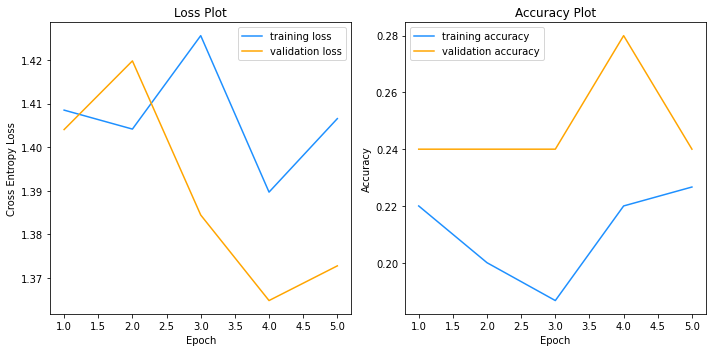

In [48]:
plot_training(train_losses, val_losses, train_accs, val_accs)

### Use TSNE to visualize GCN embeddings:

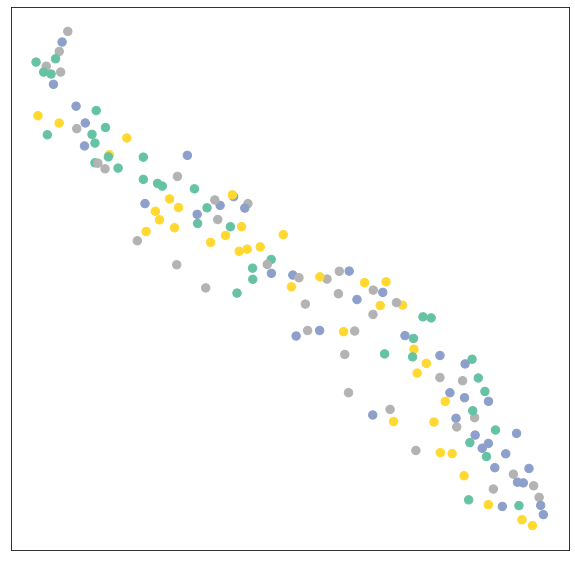

In [49]:
visualize(model, train_loader)

### Define file paths for saving GAT models and plots:

In [37]:
experiment_name = '8layer_5epoch_GAT'
os.mkdir(f'./final_project_experiments/Experiment_outputs/{experiment_name}')

save_path = f'./final_project_experiments/saved_models/{experiment_name}.pth'
training_fig_path = f'./final_project_experiments/Experiment_outputs/{experiment_name}/training_fig.png'
encoding_fig_path = f'./final_project_experiments/Experiment_outputs/{experiment_name}/encoding_fig.png'

### Train GAT Model:

In [38]:
# Create lists of metrics to average after Kfold training
accuracies = []
precisions = []
recalls = []
F1s = []

split = 0 # Keep track of split number
# Use StratifiedKFold to get folds with equal distribution of labels
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Iterate over the 4 split indexes:
for train_index, test_index in kf.split(X, y_labels):
    # Get the current split of training data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_labels[train_index], y_labels[test_index]
    
    # Divide testing split into validation and testing splits
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)
    
    # Convert all numpy arrays to torch float arrays
    X_train = torch.from_numpy(X_train).float()
    X_val = torch.from_numpy(X_val).float()
    X_test = torch.from_numpy(X_test).float()
    # Convert all numpy arrays to torch long arrays
    y_train = torch.from_numpy(y_train).long()
    y_val= torch.from_numpy(y_val).long()
    y_test = torch.from_numpy(y_test).long()
    
    # Create lists for each split of data where each element is a single graph Data object
    # containing one sample of training
    train_data = []
    for i in range(X_train.shape[0]):
        data = Data(x=X_train[i], edge_index=torch.Tensor(edge_index).long().t(), y=y_train[i])
        train_data.append(data)

    val_data = []
    for i in range(X_val.shape[0]):
        data = Data(x=X_val[i], edge_index=torch.Tensor(edge_index).long().t(), y=y_val[i])
        val_data.append(data)

    test_data = []
    for i in range(X_test.shape[0]):
        data = Data(x=X_test[i], edge_index=torch.Tensor(edge_index).long().t(), y=y_test[i])
        test_data.append(data)
    
    # Create DataLoader object from the Data lists
    train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=1, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=1, shuffle=True) 
    
    # Define the GAT
    model = GAT(feature_dim=feature_dim, hidden_dim=hidden_dim, num_classes=num_classes)
    
    # Use CrossEntropyLoss for classifcation
    loss_fn = torch.nn.CrossEntropyLoss()
    # Use Adam optimizer with .01 LR
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
    # Use GPU
    model = model.to(device)

    # Keep track of losses and accuracies for plots
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # Variable used to keep track of the best accuracy achieved
    best_val_acc = 0

    for epoch in range(num_epochs):
        # Train one epoch
        train_loss, h, train_acc = train(train_loader)
        # Get validation metrics
        val_loss, val_acc = test(val_loader)

        # Update loss and acc lists
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # If the combined training and testing accuracy is the best yet,
        # save the model for use in evaluation later. This ensures the
        # best model is used for evaluation
        if (val_acc + train_acc) > best_val_acc:
            best_val_acc = val_acc + train_acc
            torch.save(model.state_dict(), save_path)

        print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
      
    # Create and load the best model from the current training split
    model = GAT(feature_dim=feature_dim, hidden_dim=hidden_dim, num_classes=num_classes)
    model.load_state_dict(torch.load(save_path))
    model.to(device)
    # Evaluate the model
    acc, precision, recall, f1 = eval(model, test_loader)
    
    # Update metric lists
    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    F1s.append(f1)
    
    print(f'Split {split} evaluatation: Acc: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 : {f1:.4f}\n')
    split+=1

# Print the averaged metrics across the 4 splits
print(f'Average Evaluation Metrics: Acc {sum(accuracies)/4:.4f}, Precision: {sum(precisions)/4:.4f}, Recall: {sum(recalls)/4:.4f}, F1: {sum(F1s)/4:.4f}')


Epoch: 000, Loss: 1.3862, Train Acc: 0.2333, Val Acc: 0.2400
Epoch: 001, Loss: 1.3577, Train Acc: 0.2200, Val Acc: 0.2400
Epoch: 002, Loss: 1.4169, Train Acc: 0.2133, Val Acc: 0.2400
Epoch: 003, Loss: 1.4018, Train Acc: 0.1867, Val Acc: 0.2400
Epoch: 004, Loss: 1.3237, Train Acc: 0.2400, Val Acc: 0.2400
Split 0 evaluatation: Acc: 0.2400, Precision: 0.2400, Recall: 0.2400, F1 : 0.2400

Epoch: 000, Loss: 1.3857, Train Acc: 0.1933, Val Acc: 0.2400
Epoch: 001, Loss: 1.3808, Train Acc: 0.2200, Val Acc: 0.2400
Epoch: 002, Loss: 1.3503, Train Acc: 0.2400, Val Acc: 0.2400
Epoch: 003, Loss: 1.3935, Train Acc: 0.2467, Val Acc: 0.2400
Epoch: 004, Loss: 1.3791, Train Acc: 0.2067, Val Acc: 0.2400
Split 1 evaluatation: Acc: 0.2400, Precision: 0.2400, Recall: 0.2400, F1 : 0.2400

Epoch: 000, Loss: 1.4250, Train Acc: 0.2267, Val Acc: 0.2800
Epoch: 001, Loss: 1.3983, Train Acc: 0.2067, Val Acc: 0.2400
Epoch: 002, Loss: 1.4064, Train Acc: 0.2267, Val Acc: 0.2400
Epoch: 003, Loss: 1.3601, Train Acc: 0.25

### Plot GAT training loss and accuracy:

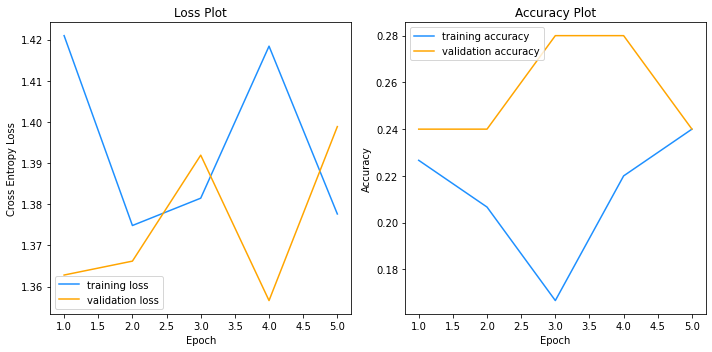

In [41]:
plot_training(train_losses, val_losses, train_accs, val_accs)

### Use TSNE to visualize GAT embeddings:

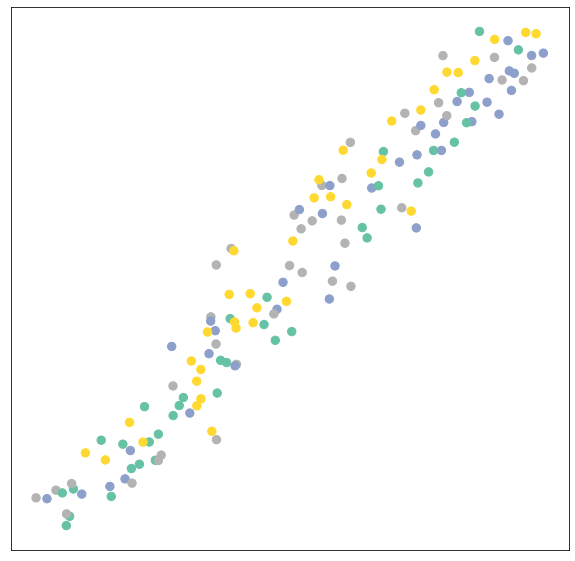

In [46]:
visualize(model, train_loader)

### Define file paths for saving ST-GCN models and plots:

In [50]:
experiment_name = '8layer_5epoch_STGCN'
os.mkdir(f'./final_project_experiments/Experiment_outputs/{experiment_name}')

save_path = f'./final_project_experiments/saved_models/{experiment_name}.pth'
training_fig_path = f'./final_project_experiments/Experiment_outputs/{experiment_name}/training_fig.png'
encoding_fig_path = f'./final_project_experiments/Experiment_outputs/{experiment_name}/encoding_fig.png'

### Train ST-GCN  Model:

In [52]:
# Create lists of metrics to average after Kfold training
accuracies = []
precisions = []
recalls = []
F1s = []

# redefine hidden_dim for ST-GCN
hidden_dim = 512

split = 0 # Keep track of split number
# Use StratifiedKFold to get folds with equal distribution of labels
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Iterate over the 4 split indexes:
for train_index, test_index in kf.split(X, y_labels):
    # Get the current split of training data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_labels[train_index], y_labels[test_index]
    
    # Divide testing split into validation and testing splits
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)
    
    # Convert all numpy arrays to torch float arrays
    X_train = torch.from_numpy(X_train).float()
    X_val = torch.from_numpy(X_val).float()
    X_test = torch.from_numpy(X_test).float()
    # Convert all numpy arrays to torch long arrays
    y_train = torch.from_numpy(y_train).long()
    y_val= torch.from_numpy(y_val).long()
    y_test = torch.from_numpy(y_test).long()
    
    # Create lists for each split of data where each element is a single graph Data object
    # containing one sample of training
    train_data = []
    for i in range(X_train.shape[0]):
        data = Data(x=X_train[i], edge_index=torch.Tensor(edge_index).long().t(), y=y_train[i])
        train_data.append(data)

    val_data = []
    for i in range(X_val.shape[0]):
        data = Data(x=X_val[i], edge_index=torch.Tensor(edge_index).long().t(), y=y_val[i])
        val_data.append(data)

    test_data = []
    for i in range(X_test.shape[0]):
        data = Data(x=X_test[i], edge_index=torch.Tensor(edge_index).long().t(), y=y_test[i])
        test_data.append(data)
    
    # Create DataLoader object from the Data lists
    train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=1, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=1, shuffle=True) 
    
    # Define the STGCN
    model = STGCN(feature_dim=feature_dim, hidden_dim=hidden_dim, num_classes=num_classes)
    
    # Use CrossEntropyLoss for classifcation
    loss_fn = torch.nn.CrossEntropyLoss()
    # Use Adam optimizer with .01 LR
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
    # Use GPU
    model = model.to(device)

    # Keep track of losses and accuracies for plots
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # Variable used to keep track of the best accuracy achieved
    best_val_acc = 0

    for epoch in range(num_epochs):
        # Train one epoch
        train_loss, h, train_acc = train(train_loader)
        # Get validation metrics
        val_loss, val_acc = test(val_loader)

        # Update loss and acc lists
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # If the combined training and testing accuracy is the best yet,
        # save the model for use in evaluation later. This ensures the
        # best model is used for evaluation
        if (val_acc + train_acc) > best_val_acc:
            best_val_acc = val_acc + train_acc
            torch.save(model.state_dict(), save_path)

        print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
      
    # Create and load the best model from the current training split
    model = STGCN(feature_dim=feature_dim, hidden_dim=hidden_dim, num_classes=num_classes)
    model.load_state_dict(torch.load(save_path))
    model.to(device)
    # Evaluate the model
    acc, precision, recall, f1 = eval(model, test_loader)
    
    # Update metric lists
    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    F1s.append(f1)
    
    print(f'Split {split} evaluatation: Acc: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 : {f1:.4f}\n')
    split+=1

# Print the averaged metrics across the 4 splits
print(f'Average Evaluation Metrics: Acc {sum(accuracies)/4:.4f}, Precision: {sum(precisions)/4:.4f}, Recall: {sum(recalls)/4:.4f}, F1: {sum(F1s)/4:.4f}')


Epoch: 000, Loss: 1.3880, Train Acc: 0.2133, Val Acc: 0.2800
Epoch: 001, Loss: 1.4166, Train Acc: 0.1600, Val Acc: 0.2400
Epoch: 002, Loss: 1.4223, Train Acc: 0.1733, Val Acc: 0.2400
Epoch: 003, Loss: 1.3909, Train Acc: 0.1867, Val Acc: 0.2400
Epoch: 004, Loss: 1.4085, Train Acc: 0.2400, Val Acc: 0.2400
Split 0 evaluatation: Acc: 0.2400, Precision: 0.2400, Recall: 0.2400, F1 : 0.2400

Epoch: 000, Loss: 1.3457, Train Acc: 0.2400, Val Acc: 0.2400
Epoch: 001, Loss: 1.3582, Train Acc: 0.1933, Val Acc: 0.2400
Epoch: 002, Loss: 1.3575, Train Acc: 0.2133, Val Acc: 0.2400
Epoch: 003, Loss: 1.4106, Train Acc: 0.2467, Val Acc: 0.2800
Epoch: 004, Loss: 1.4109, Train Acc: 0.2267, Val Acc: 0.2400
Split 1 evaluatation: Acc: 0.2400, Precision: 0.2400, Recall: 0.2400, F1 : 0.2400

Epoch: 000, Loss: 1.4002, Train Acc: 0.2133, Val Acc: 0.2400
Epoch: 001, Loss: 1.4251, Train Acc: 0.2133, Val Acc: 0.2400
Epoch: 002, Loss: 1.3798, Train Acc: 0.2333, Val Acc: 0.2400
Epoch: 003, Loss: 1.3665, Train Acc: 0.19

### Plot ST-GCN training loss and accuracy:

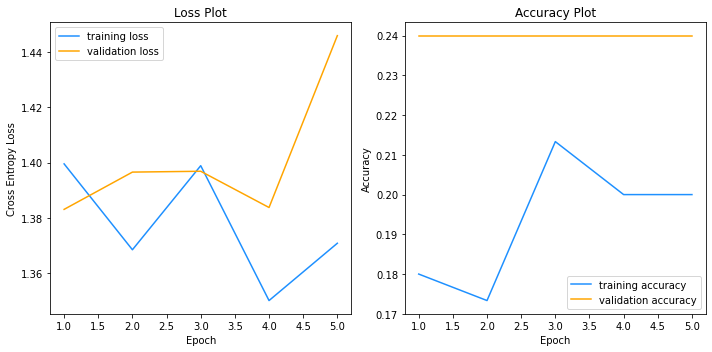

In [53]:
plot_training(train_losses, val_losses, train_accs, val_accs)

### Use TSNE to visualize ST-GCN embeddings:

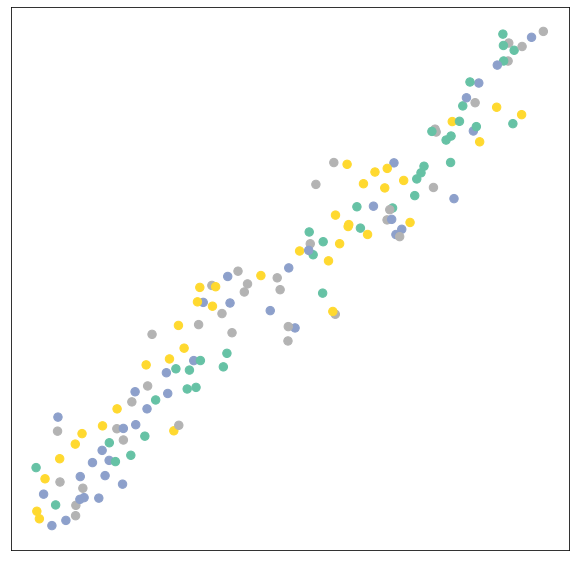

In [54]:
visualize(model, train_loader)